In [1]:
import pandas as pd
import numpy as np
import requests
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
import geocoder
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from sklearn import preprocessing
import matplotlib.pyplot as plt

Read in Table from Wikipedia by excluding 'Not assigned borough:

In [2]:
url=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
table0 = pd.read_html(url,header=0)[0]
table=table0[table0['Borough']!='Not assigned']
table=table.reset_index(drop='index')

Read in geographical coordinates of the neighborhoods from csv file:

In [3]:
geo=pd.read_csv('http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv')

Merge table from wikipedia and geographical coordinates of the neighborhoods by postal code:

In [4]:
df=pd.merge(table,geo, on='Postal Code', how='left')
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Include only boroughs that contain the word Toronto: 'Downtown Toronto', 'Central Toronto','West Toronto','East Toronto'. It can be determined by running the frequency of boroughs below:  

In [5]:
df['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East Toronto         5
East York            5
Mississauga          1
Name: Borough, dtype: int64

In [6]:
toronto_data=df.loc[df['Borough'].isin (['Downtown Toronto', 'Central Toronto','West Toronto','East Toronto'])]
toronto_data=toronto_data.reset_index(drop='index')
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


Check to see whether all boroughs with word Toronto is included: 

In [7]:
toronto_data.shape

(39, 5)

According to frequency of Borough shown above, Downtown Toronto=19, Central Toronto=9, West Toronto=6 and East Toronto=5. It sums up to be 39. It matches the rows in the dataframe.

Using Foursquare, obtain geograpical coordinate of Toronto (latitude and longitude): 

In [9]:
address='Toronto,Ontario'
geolocator=Nominatim(user_agent='foursquare_agent')
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print('The geograpical coordinate of Toronto are {},{}'.format(latitude,longitude))

The geograpical coordinate of Toronto are 43.6534817,-79.3839347


Explore and cluster the neighborhoods in Toronto.

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results0=requests.get(url).json()
        results=results0['response']['groups'][0]['items']

        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list 
                                  for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
toronto_venues=getNearbyVenues(names=toronto_data['Neighborhood'].to_list(),
                                latitudes=toronto_data['Latitude'].to_list(),
                                longitudes=toronto_data['Longitude'].to_list())

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [12]:
toronto_venues.shape

(1621, 7)

In [13]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",14,14,14,14,14,14
Central Bay Street,63,63,63,63,63,63
Christie,17,17,17,17,17,17
Church and Wellesley,78,78,78,78,78,78
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34


In [14]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 237 unique categories.


In [15]:
toronto_onehot=pd.get_dummies(toronto_venues[['Venue Category']],
                               prefix='', prefix_sep='')
toronto_onehot['Neighborhood']=toronto_venues['Neighborhood']
fixed_columns=[toronto_onehot.columns[-1]]+list(toronto_onehot.columns[:-1])
toronto_onehot=toronto_onehot[fixed_columns]
toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [16]:
toronto_onehot.shape

(1621, 237)

In [17]:
toronto_grouped=toronto_onehot.groupby("Neighborhood").mean().reset_index()
toronto_grouped.shape

(39, 237)

The top 10 venues for each neighborhood:

In [18]:
def return_most_common_venues(row,num_top_venues):
    row_categories=row.iloc[1:]
    row_categories_sorted=row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues=10
indicators=['st','nd','rd']
columns=['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1,indicator[ind]))
    except:
        columns.append('{}th Most common Venue'.format(ind+1))
neighborhoods_venues_sorted=pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood']=toronto_grouped['Neighborhood']
for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], 
                              num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1th Most common Venue,2th Most common Venue,3th Most common Venue,4th Most common Venue,5th Most common Venue,6th Most common Venue,7th Most common Venue,8th Most common Venue,9th Most common Venue,10th Most common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Pub,Cheese Shop,Restaurant,Seafood Restaurant,Bakery,Beer Bar,Café,Shopping Mall
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Grocery Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Auto Workshop,Smoke Shop,Brewery,Spa,Farmers Market,Fast Food Restaurant,Burrito Place,Butcher,Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Boat or Ferry,Boutique,Airport,Airport Food Court,Harbor / Marina,Bar,Sculpture Garden
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Ice Cream Shop,Japanese Restaurant,Salad Place,Bubble Tea Shop,Yoga Studio


In [38]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

Normalize data

In [21]:
scaler = preprocessing.StandardScaler()
scaler.fit(toronto_grouped_clustering)
X= scaler.transform(toronto_grouped_clustering)

Determine optimal k using Within-Cluster-Sum of Squared Errors (WSS):

In [22]:
sse = []
def calculate_WSS(points, kmax):
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
        sse.append(curr_sse)
    return sse

In [23]:
calculate_WSS(X,10)

[78.00000000000007,
 75.80490071676174,
 77.13032137826929,
 75.36879230057644,
 36.517113851874086,
 23.293839159811657,
 34.451957793463464,
 34.11041518174777,
 32.977823263499864,
 32.20226352609715]

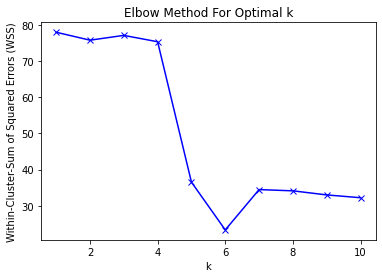

In [24]:
K=range(1,11)
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
plt.title('Elbow Method For Optimal k')
plt.show()

Based on the Elbow method, k=6 is chosen. 

In [39]:
kclusters = 6
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

In [40]:
neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)
toronto_merged=toronto_data
toronto_merged=toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')

In [41]:
toronto_merged['Cluster Labels'].value_counts()

0    34
5     1
4     1
3     1
2     1
1     1
Name: Cluster Labels, dtype: int64

Based on the frequency of cluster labels above, 34 out of 39 (about 87%) of Toronto neighborhoods seem to have similar characteristics. 5 out of 39 (about 13%) of Toronto neighborhoods seem to have unique charaterictics and each of those neighborhoods forms its own cluster.   

Generate map to visualize Toronto neighborhoods and how they cluster together:

In [42]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, a name to each cluster is assigned.

Cluster 1. Coffee shops and restaurants area

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1th Most common Venue,2th Most common Venue,3th Most common Venue,4th Most common Venue,5th Most common Venue,6th Most common Venue,7th Most common Venue,8th Most common Venue,9th Most common Venue,10th Most common Venue
0,Downtown Toronto,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Mexican Restaurant,Shoe Store,Restaurant
1,Downtown Toronto,0,Coffee Shop,Yoga Studio,Creperie,Beer Bar,Smoothie Shop,Sandwich Place,Burger Joint,Burrito Place,Restaurant,Café
2,Downtown Toronto,0,Clothing Store,Coffee Shop,Café,Middle Eastern Restaurant,Cosmetics Shop,Italian Restaurant,Japanese Restaurant,Restaurant,Bubble Tea Shop,Tea Room
3,Downtown Toronto,0,Café,Coffee Shop,Cocktail Bar,American Restaurant,Gastropub,Restaurant,Hotel,Cosmetics Shop,Creperie,Lingerie Store
4,East Toronto,0,Park,Coffee Shop,Trail,Health Food Store,Pub,Women's Store,Distribution Center,Department Store,Dessert Shop,Diner
5,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Pub,Cheese Shop,Restaurant,Seafood Restaurant,Bakery,Beer Bar,Café,Shopping Mall
6,Downtown Toronto,0,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Ice Cream Shop,Japanese Restaurant,Salad Place,Bubble Tea Shop,Yoga Studio
7,Downtown Toronto,0,Grocery Store,Café,Park,Baby Store,Nightclub,Athletics & Sports,Italian Restaurant,Diner,Candy Store,Restaurant
8,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Clothing Store,Gym,Hotel,Deli / Bodega,Thai Restaurant,Sushi Restaurant,Salad Place
9,West Toronto,0,Bakery,Pharmacy,Grocery Store,Pool,Brewery,Café,Bar,Bank,Supermarket,Middle Eastern Restaurant


Cluster 2. Pool area

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1th Most common Venue,2th Most common Venue,3th Most common Venue,4th Most common Venue,5th Most common Venue,6th Most common Venue,7th Most common Venue,8th Most common Venue,9th Most common Venue,10th Most common Venue
18,Central Toronto,1,Park,Bus Line,Swim School,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run


Cluster 3. Home service and garden area

In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1th Most common Venue,2th Most common Venue,3th Most common Venue,4th Most common Venue,5th Most common Venue,6th Most common Venue,7th Most common Venue,8th Most common Venue,9th Most common Venue,10th Most common Venue
19,Central Toronto,2,Ice Cream Shop,Home Service,Garden,Women's Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


Cluster 4. Jewerly district

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1th Most common Venue,2th Most common Venue,3th Most common Venue,4th Most common Venue,5th Most common Venue,6th Most common Venue,7th Most common Venue,8th Most common Venue,9th Most common Venue,10th Most common Venue
21,Central Toronto,3,Park,Jewelry Store,Trail,Sushi Restaurant,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


Cluster 5. Park and trail area

In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1th Most common Venue,2th Most common Venue,3th Most common Venue,4th Most common Venue,5th Most common Venue,6th Most common Venue,7th Most common Venue,8th Most common Venue,9th Most common Venue,10th Most common Venue
33,Downtown Toronto,4,Park,Playground,Trail,Cupcake Shop,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


Cluster 6. Kids and family friendly area

In [48]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1th Most common Venue,2th Most common Venue,3th Most common Venue,4th Most common Venue,5th Most common Venue,6th Most common Venue,7th Most common Venue,8th Most common Venue,9th Most common Venue,10th Most common Venue
29,Central Toronto,5,Playground,Summer Camp,Restaurant,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run
